# Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

- A/B tests are used to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group sees the new version. A metric is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing is very much like hypothesis testing with the following hypotheses:


- **Null Hypothesis**: The new version is no better, or even worse, than the old version

- **Alternative Hypothesis**: The new version is better than the old version


- If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. These tests can be used for a wide variety of changes, from large feature additions to small adjustments in color, to see what change maximizes your metric the most.


- A/B testing also has its drawbacks. It can help you compare two options, but it can't tell you about an option you haven’t considered. It can also produce bias results when tested on existing users, due to factors like change aversion and novelty effect.


- **Change Aversion**: Existing users may give an unfair advantage to the old version, simply because they are unhappy with change, even if it’s ultimately for the better.

- **Novelty Effect**: Existing users may give an unfair advantage to the new version, because they’re excited or drawn to the change, even if it isn’t any better in the long run.


- For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal of this project is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

 -So let's get start by importing required ibraries.

#### Importing the libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(42)

In [37]:
import statsmodels.api as sm

In [38]:
df = pd.read_csv('ab_data.csv')

- Reading the dataset and take a look at the top 5 rows

In [39]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [40]:
len(df)

294478

- The number of unique users in the dataset are

In [41]:
df.user_id.nunique()

290584

- The proportion of users converted

In [42]:
converted_proportion = df.query('converted == 1')['user_id'].nunique()/df.user_id.nunique()
print(converted_proportion)

0.12104245244060237


- Checking if there is any missing values

In [43]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

- The number of times the new_page and treatment don't line up is `1928+1965` from the following table

In [44]:
df.groupby(["group", "landing_page"]).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

- Removing Wrong Entries

In [45]:
df[(((df.group == 'control') & (df.landing_page == 'new_page')) | ((df.group == 'treatment') & (df.landing_page == 'old_page')))].index

Int64Index([    22,    240,    308,    327,    357,    490,    685,    713,
               776,    846,
            ...
            293817, 293888, 293894, 293917, 293996, 294014, 294200, 294252,
            294253, 294331],
           dtype='int64', length=3893)

In [46]:
len(df)

294478

In [47]:
df2 = df.drop(df[(((df.group == 'control') & (df.landing_page == 'new_page')) | ((df.group == 'treatment') & (df.landing_page == 'old_page')))].index)

In [48]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [49]:
len(df2)

290585

In [50]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

- Checking unique users in the new dataframe

In [51]:
df2.user_id.nunique()

290584

 - Checking and Removing the duplicate users

In [52]:
df2[df2.duplicated(subset = ["user_id"], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [53]:
duplicate_index = df2[df2.duplicated(subset = ["user_id"], keep = False)].index
print(duplicate_index)

Int64Index([1899, 2893], dtype='int64')


In [54]:
df2.drop_duplicates(subset = ['user_id'],keep=False,inplace=True)

In [55]:
df2[df2.duplicated(subset = ["user_id"])]

,user_id,timestamp,group,landing_page,converted


- Probability of an individual converting regardless of the page they receive

In [56]:
df2.query('converted == 1')['user_id'].nunique()/df2.user_id.nunique()

0.11959749882133504

In [57]:
df2.converted.mean()

0.11959749882133504

- Given that an individual was in the `control` group, what is the probability they converted?

In [58]:
df2[df2.group == 'control'].converted.mean()

0.1203863045004612

- Given that an individual was in the `treatment` group, what is the probability they converted?

In [59]:
df2[df2.group == 'treatment'].converted.mean()

0.11880888313869065

- Probability that an individual received the new page

In [60]:
len(df2[df2.landing_page == 'new_page'])/len(df2)

0.5000602237570677

In [61]:
len(df2.query("group == 'treatment' and converted == 1"))

17264

In [62]:
len(df2.query("group == 'control' and converted == 1"))

17489

#### Observations 

- Probability of an individual converting regardless of the page they receive is `11.95%`


- 17264 unique userd converted  from `control` group.


- 17489 unique userd converted  from `treatment` group.


-  This small difference in conversion between these two groups could also appear by chance, therefore we don't have sufficient evidence to conclude that the new treatment page leads to more conversions than the old page.


- The no of unique users from `control` and `treatment` groups are approximately same, It's good because now we can be confident about out results as we have taken approximately equal number of unique from both groups without any bias.

### Part II - A/B Test


- Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.


- However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?


- These questions are the difficult parts associated with A/B tests in general.


- Here I'm considering the  all the data provided to make a decision.


- I'm assuming that old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.


- So my null hypothesis **$H_{0}$** : **$p_{old}$** - **$p_{new}$** >= 0 


- And my alternative hypothesis **$H_{1}$** : **$p_{old}$** - **$p_{new}$** < 0 


- Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

- **convert rate** for $p_{new}$ under the null

In [63]:
p_new = df2.converted.mean()
print(p_new)

0.11959749882133504


- **convert rate** for $p_{old}$ under the null

In [64]:
p_old = df2.converted.mean()
print(p_old)

0.11959749882133504


- $n_{new}$

In [65]:
n_new = len(df2[df2.group == 'treatment'])
print(n_new)

145309


- $n_{old}$

In [66]:
n_old =len(df2[df2.group == 'control'])
print(n_old)

145274


- Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [67]:
new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
print(len(new_page_converted))
print(new_page_converted.sum())
print(new_page_converted.mean())

145309
17266
0.11882264691106538


- Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [68]:
old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = (p_old, 1-p_old))
print(len(old_page_converted))
print(old_page_converted.sum())
print(old_page_converted.mean())

145274
17269
0.11887192477662899


- Finding $p_{new}$ - $p_{old}$ for your simulated values from earlier two steps

In [69]:
obs_diff = new_page_converted.mean() - old_page_converted.mean() 
print(obs_diff)

-4.927786556360725e-05


In [70]:
p_diffs = []
for i in range(10000):
    old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = (p_old, 1-p_old))
    new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
    difference = new_page_converted.mean() - old_page_converted.mean() 
    p_diffs.append(difference)

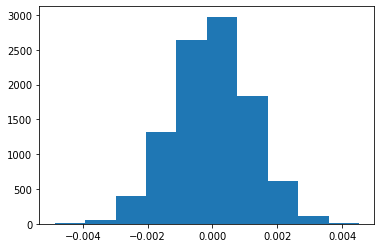

In [71]:
plt.hist(p_diffs);

In [72]:
control_group = df2[df2.group == 'control']
print(control_group.converted.sum())
print(control_group.converted.mean())

17489
0.1203863045004612


In [73]:
treatment_group = df2[df2.group == 'treatment']
print(treatment_group.converted.sum())
print(treatment_group.converted.mean())

17264
0.11880888313869065


In [74]:
actual_difference = treatment_group.converted.mean() - control_group.converted.mean()
print(actual_difference)

-0.0015774213617705535


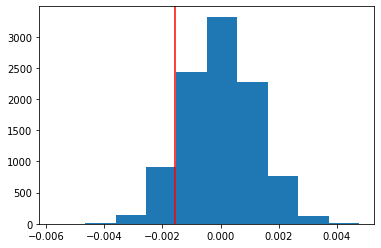

In [75]:
null_vals = np.random.normal(0, np.std(p_diffs), 10000)
plt.hist(null_vals);
plt.axvline(actual_difference, color = 'r');

In [76]:
(null_vals > actual_difference).mean()

0.9023

#### Observations 

- **p-value** is the probability of observing our statistic or a more extreme statistic from the null hypothesis.


- This is a right tail test and the p-value we obtained from the test is 0.904 and which is greater than significance level (alpha) 0.05. Since **p** > **alpha**, we can't reject the null hypothesis **$H_{0}$**.


- So we can conclude that the old page has a higher convertion rate than the new page. So we shouldn't incorporate this in the e-commerce website.
 

In [77]:
convert_old = control_group.converted.mean()
convert_new = treatment_group.converted.mean()
n_old = len(control_group) 
n_new = len(treatment_group)

In [146]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print('Z-score: ', z_score)
print('P-value: ', p_value)

Z-score:  -1.3102408579271012
P-value:  0.9049428161159749


#### Observations

- The **p-value** calculated using the built-in libraries is exactly matching with the what we have got by a traditional method, so our conclusion also will be the same that the old page has a higher convertion rate than the new page. So we shouldn't incorporate this in the e-commerce website.

<a id='regression'></a>
### Part III - Regression approach


In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.


- Since each row is either a conversion or no conversion, we will be using logistic regression to perform this case.


- The goal here is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. 


- However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  And also we need to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

#### Creating Dummies

In [150]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [151]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1


In [152]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


#### Instantiating and fitting the model

In [153]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


#### Summary of the Logit model

In [154]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Apr 2020   Pseudo R-squ.:               8.068e-06
Time:                        17:57:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1901
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
==============================================================================
"""

- The p-value (0.190) here remains above an $\alpha$ level of 0.05 but is different because this is a two tailed test. We will still reject the null in this situation.


- Now we will try to ass more explanatory variables to that the model has enough information to understand the variation in the target variable.

In [174]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [177]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [178]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [182]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [183]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [184]:
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Apr 2020   Pseudo R-squ.:               1.520e-05
Time:                        18:16:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.745      0.456      -0.016       0.036
==============================================================================
"""

- Here, the p-values for countries are well above a 0.05 $\alpha$ level. And so we fail to reject the null and conclude that on it's own, there is no significant contribution from country to differences in conversion rates for the two pages.


- Now we will check for an interaction

In [185]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [186]:
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 Apr 2020   Pseudo R-squ.:               3.481e-05
Time:                        18:23:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1922
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.504      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.180      0.238      -0.021       0.084
==============================================================================
"""

- From the summary we can observe that none one of the variables included in the model have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.


- In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.